# Classification and Regression Trees (CART)

Decision tree can be used to build classification and regression algorithms, known as classification trees and decision trees. Decision tree themselves are not desirable as their decision boundaries don't have additive structures and the "sweet spot" of the model complexity is hard to find. However, if combined with ensemble methods such as bagging or boosting, decision tree learning can be very powerful.

The idea behind CART is to partition the feature space so that in the end each region (leaf node) contain data points as pure as possible, i.e. only data points with one label. If the depth of tree is large enough, a tree-based classifier can separate any dataset, though at the risk of overfitting. We start with a dataset $D=\left\{(\mathbf{x}^{(i)}, t^{(i)})\right\}_{i=1, \ldots, N}$, where $\mathbf{x}^{(i)} = (x^{(i)}_1, ... , x^{(i)}_d)\in \mathbb{R}^d$ is the feature and $t^{(i)}\in\{1,...,K\}$ is the class label. We start with all the data in a single class. We then consider a split point $(j,s)$ such that it defines the two regions $R_1(j,s) = \left\{x|x_j\leq s\right\}$ and $R_2(j,s) = \left\{x|x_j\geq s\right\}$. We denote the data points in $D_k:=\{(x,t)\in D\mid t=k\}$ by $S_k$. The split coordinate $s$ should be some midpoint of two data points along the $j$-th direction. At each step, the optimal split is chosen such that the "impurity" of each class is minimized. Two commonly used measures are the Gini impurity and entropy.

For a dataset $D$ let $p_k:=\frac{|D_k|}{|D|}$ $(k=1,...,K)$. The Gini impurity of $D$ is defined by $$G(D):=\sum_{k=1}^K p_k(1-p_k),$$ which is concave and (by Lagrange multiplier) attains it max at $p_1=\cdots=p_K=\frac{1}{K}$. At each split the objective is 

$$ \min_{j,s} \frac{|S_1|}{|D|} G(S_1)+\frac{|S_2|}{|D|} G(S_2),$$

namely, the weighted average of the Gini impurity of the two subregions. A more popular approach is to use the entropy. Specifically, we want our the probability distribution $P: p_1,...,p_K$ (on the sample space $\{1,...,K\}$) to be as dissimilar as the distribution $Q: q_1=\cdots=q_K=\frac{1}{K}$ as possible, so we need to maximize the KL-divergence
$$KL(P||Q)=\sum_{k=1}^K p_k\log\frac{p_k}{q_k} =\sum_{k=1}^K p_k\log p_k + \log K.$$

Define $H(D)=-\sum_{k=1}^K p_k\log p_k$. Then at each step the optimization problem is

$$ \min_{j,s} \frac{|S_1|}{|D|} H(S_1)+\frac{|S_2|}{|D|} H(S_2),$$


We recursively split the regions until no misclassification occurs in each leaf. Possible regularization approaches include limiting the maximum number of nodes, the maximum depth, the minimum leaf size, or pruning.

For classification problem we can use the square loss: at each split we solve

$$\begin{align}
\min_{j, s} \left[\min_{c_1} \sum_{\mathbf{x}^{(i)}\in R_1(j, s)} (t^{(i)} - c_1)^2 + \min_{c_2} \sum_{\mathbf{x}^{(i)}\in R_2(j, s)} (t^{(i)} - c_2)^2\right]
\end{align},$$

for which the inner minimization is solved by 

$$ \hat{c}_1 = \text{average}(t^{(i)}|\mathbf{x}_i \in R_1(j, s)) \hspace{10pt}\text{ and }\hspace{10pt}\hat{c}_2 = \text{average}(t^{(i)}|\mathbf{x}_i \in R_2(j, s))$$

Now we consider the folloing dataset:

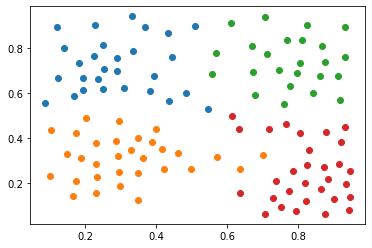

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from collections import Counter

# load data
class1 = scipy.io.loadmat('class1.mat')['class1']
class2 = scipy.io.loadmat('class2.mat')['class2']
class3 = scipy.io.loadmat('class3.mat')['class3']
class4 = scipy.io.loadmat('class4.mat')['class4']

# this is the original data
plt.scatter(class1[:,0], class1[:,1])
plt.scatter(class2[:,0], class2[:,1])
plt.scatter(class3[:,0], class3[:,1])
plt.scatter(class4[:,0], class4[:,1])
plt.show()

In [4]:
# define the target variables
t_class1 = 1 * np.ones((np.shape(class1)[0], 1))
t_class2 = 2 * np.ones((np.shape(class2)[0], 1))
t_class3 = 3 * np.ones((np.shape(class3)[0], 1))
t_class4 = 4 * np.ones((np.shape(class4)[0], 1))

# stack the labels and the targets
x = np.vstack((class1, class2, class3, class4))
t = np.vstack((t_class1, t_class2, t_class3, t_class4))
data = np.hstack((x,t))

First of all, we define functions that compute the two type of impurity measures.

In [5]:
def gini(t, num_class):
    '''This function compute the gini impurity for a dataset with t being its categorical label vector'''
    gini = 0
    for k in range(num_class):
        p_k = np.sum(t==(k+1)) / len(t) # our class starts from 1
        gini = gini + p_k*(1-p_k)
    return gini

In [6]:
def entropy(t, num_class):
    '''This function compute the entropy for a dataset with t being its categorical label vector'''
    entropy = 0
    for k in range(num_class):
        p_k = np.sum(t==(k+1)) / len(t) # our class starts from 1
        if p_k==0:
            pass
        else:
            entropy = entropy - p_k * np.log2(p_k)
    return entropy

Now define the loss of a split:

In [7]:
def impurity(x, target, num_class, type):
    '''
    This function takes in feature vectors x, the corresponding categorical target t, and the type of impurity measure being used
    (either 'gini', 'entropy' or 'square') and it returns the minimum split loss of the dataset and an array recording the loss associated 
    with each data point as the split point
    '''
    num_points = np.size(target) # number of data points
    loss = np.zeros((2,num_points)) # placeholder for the losses for each pair (j,s)
    for j in range(np.shape(x)[1]): # for each direction
        for s in range(num_points):
            r1_ind = (x <= x[s][j])[:,j] # compute the indices for the first region R1
            r2_ind = np.logical_not(r1_ind) # compute the indices for the second region R2
            t1 = target[r1_ind] # labels from the first class
            t2 = target[r2_ind] # labels from the second class
            
            if type=='gini':
                if len(t1)!=0 and len(t2)!=0:
                    loss[j][s] = ( np.size(t1)*gini(t1, num_class) + np.size(t2)*gini(t2, num_class) ) / num_points
                elif len(t1)!=0 and len(t2)==0:
                    loss[j][s] = gini(t1, num_class)
                elif len(t1)==0 and len(t2)!=0:
                    loss[j][s] = gini(t2, num_class)
                else:
                    loss[j][k]=0
            elif type=='entropy':
                if len(t1)!=0 and len(t2)!=0:
                    loss[j][s] = ( np.size(t1)*entropy(t1, num_class) + np.size(t2)*entropy(t2, num_class) ) / num_points
                elif len(t1)!=0 and len(t2)==0:
                    loss[j][s] = entropy(t1, num_class)
                elif len(t1)==0 and len(t2)!=0:
                    loss[j][s] = entropy(t2, num_class)
                else:
                    loss[j][k]=0
            elif type=='square':
                c1 = np.mean(t1) # compute c1_hat for the first inner min 
                c2 = np.mean(t2) # compute c2_hat for the second inner min
                loss[j][s] = np.sum( np.square(t1-c1)) + np.sum( np.square(t2-c2)) # compute the loss
            else:
                print("Invalid impurity type")
                return
    min_loss = np.min(loss) # compute the minimum loss over all possible j and s
    return min_loss, loss

Now define the function that performs a single split:

In [8]:
def split(x, target, num_class, type):
    '''
    This function takes in features x and corresponding categorical target t, and it returns the following:
    1. the best split index j and s, where j is the split direction and s is the split coordicate
    2. the indices of the points in R1
    3. the indices of the points in R2
    '''
    min_loss, loss = impurity(x,target, num_class, type)    
    min_index = np.argwhere(loss==min_loss)[0] # compute the indices of elements in x with min_loss and choose the first one
    # compute the boolean arrays that indicate which class a data point belong to
    r1_ind = (x <= x[min_index[1], min_index[0]])[:,min_index[0]] # compute the indices for the first region R1
    r2_ind = np.logical_not(r1_ind) # compute the indices for the second region R2   
    return min_index[0], min_index[1], r1_ind, r2_ind

Finally, define a function that recursively build the classification tree until no further improvement can be made. It is implemented for two dimensional features for visualization purpose.

In [13]:
def classification_tree(data, xx0, xx1, num_class, current_mesh, predictions, type):
    ''' 
    This function takes in categorical data and do binary split using the "split" function until each region
    contains only one class of points, and it colors each region in different colors. Here, 
    1. xx0 and xx1 are the overall grid
    2. current_mesh logical grids indicating the region where the current iteration calculates its value
    3. predictions stores the function values (i.e. class labels) associated with XX0 and XX1
    '''
    feature_dimension = 2
    target = data[:, feature_dimension] # all targets
    if all(target==target[0]): # if all targets are equal
        predictions[current_mesh]=target[0] # set the prediction value
    else:
        split_dir, split_ind, r1_ind, r2_ind = split(data[:,0:2], data[:,2], num_class, type)
        data1 = data[r1_ind, :] # data_1 = points in R1
        data2 = data[r2_ind, :] # data_2 = points in R2
        # see if each region needs furthur classification
        target1 = data1[:,2]
        target2 = data2[:,2]
        isdone_1 = any([all(target1==num_class) for k in range(num_class)]) # true iff R1 is homogeneous
        isdone_2 = any([all(target2==num_class) for k in range(num_class)]) # true iff R2 is homogeneous

        # To color the decision regions, we assign the labels of the class (i.e., 1-4) as function values to the points in
        # meshgrid. The fuction value on a region is determined by the label of the most common entry in that region.
        value1 = Counter(data1[:, 2]).most_common(1)[0][0] # get the most common label in R1
        value2 = Counter(data2[:, 2]).most_common(1)[0][0] # get the most common label in R2

        if split_dir == 0: # which means we are drawing a vertical line. R1 is to the left and R2 is to the right
            coordinate = data[split_ind][split_dir]
            R1 = np.logical_and(xx0 <= coordinate, current_mesh) # compute the current R1
            R2 = np.logical_and(xx0 >  coordinate, current_mesh) # compute the current R2
            predictions[R1] = value1 # set the values of predictions on R1
            predictions[R2] = value2 # set the values of predictions on R2

            # recursively classify points in R1/R2 and assign function values
            if not isdone_1:
                classification_tree(data1, xx0, xx1, num_class, R1, predictions, type)        
            if not isdone_2:
                classification_tree(data2, xx0, xx1, num_class, R2, predictions, type)

        else: # which means we are drawing a horizontal line
            coordinate = data[split_ind][split_dir]
            R1 = np.logical_and(xx1 <= coordinate, current_mesh) # compute the current R1
            R2 = np.logical_and(xx1 >  coordinate, current_mesh) # compute the current R2
            predictions[R1] = value1 # set the values of predictions on R1
            predictions[R2] = value2 # set the values of predictions on R2

            # recursively classify points in R1/R2 and assign function values
            if not isdone_1:
                classification_tree(data1, xx0, xx1, num_class, R1, predictions, type)
            if not isdone_2:
                classification_tree(data2, xx0, xx1, num_class, R2, predictions, type)                

Now we plot the result.

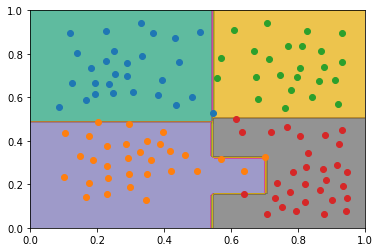

In [14]:
# Find the classification tree and plot the result
# set up the grid for plotting
x0 = np.linspace(0,1,101)
x1 = np.linspace(0,1,101)
xx0, xx1 = np.meshgrid(x0,x1)
predictions = np.zeros((len(x0),len(x1))) # where we store the function values
current_mesh = np.ones((len(x0),len(x1))) # we start with the whole region
num_class = 4

# find the classification tree
classification_tree(data, xx0, xx1, 4, current_mesh, predictions, 'square') 
# plt.contourf(xx0,xx1,current_mesh)

# now plotting
plt.contourf(xx0, xx1, predictions.reshape(np.shape(xx0)), alpha = 0.7, cmap = 'Dark2')
plt.scatter(class1[:,0], class1[:,1])
plt.scatter(class2[:,0], class2[:,1])
plt.scatter(class3[:,0], class3[:,1])
plt.scatter(class4[:,0], class4[:,1])